# Google Analytics Data Cleaning & Visualization
## Introduction:
In this project we will try to ingest data from google public domain datasets, after-which we shall clean the data by unnesting and using some of pandas function.

### Project Summary:
- Reading the data from the Google BigQuery and saving it locally as a JSON file.
- Defining unnest function to unnest nested json lists.
- We will apply data normalization technique to achieve a normal state where data visualization can be obtained.
- We shall take look at memory usage of each column and will try to lower the computation time by changing some of the dtype.
- In the end we will visualize the data by answering some of the questions that a business side can encounter.

Lets import all necessary libraries first:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#In case you want to read directly from Google BigQuery follow the below code, for our project we are working on same data as of "sql" query:

#from google.cloud import bigquery
#client = bigquery.Client()
#sql = """
#    SELECT 
#        * 
#    FROM 
#        `bigquery-public-data.google_analytics_sample.ga_sessions_20170801` 
#    LIMIT 100
#"""
# Run a Standard SQL query using the environment's default project
#df = client.query(sql).to_dataframe()
# Run a Standard SQL query with the project set explicitly
#project_id = 'your-project-id'
#df = client.query(sql, project=project_id).to_dataframe()

In [2]:
# lets read the json data
raw = pd.read_json('./google_analytics_data.json')

Let us have look at our DataFrame "raw"

In [3]:
raw.head(2)

,channelGrouping,clientId,customDimensions,date,device,fullVisitorId,geoNetwork,hits,socialEngagementType,totals,trafficSource,userId,visitId,visitNumber,visitStartTime,visitorId
0,Organic Search,NaN,[],20170801,"{'browser': 'Chrome', 'browserVersion': 'not a...",2.248282e+18,"{'continent': 'Americas', 'subContinent': 'Car...","[{'hitNumber': '1', 'time': '0', 'hour': '3', ...",Not Socially Engaged,"{'visits': '1', 'hits': '1', 'pageviews': '1',...","{'referralPath': None, 'campaign': '(not set)'...",NaN,1501583974,1,1501583974,NaN
1,Organic Search,NaN,"[{'index': '4', 'value': 'North America'}]",20170801,"{'browser': 'Chrome', 'browserVersion': 'not a...",8.647436e+18,"{'continent': 'Americas', 'subContinent': 'Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '12',...",Not Socially Engaged,"{'visits': '1', 'hits': '1', 'pageviews': '1',...","{'referralPath': None, 'campaign': '(not set)'...",NaN,1501616585,1,1501616585,NaN


#### We have lots of Nested Arrays to deal with!

No Worries!

Let us define a function that can take care of all nested columns and later we will be deleting all the unnecessary nested columns.

##### Here, Below is the code that shall unnest a passed column, Let us follow the steps.

- As we can see, it takes two parameters, data, & column_name.
- Firstly, this code will get length of each and every entity in the column and stored it in length list.
- Next, it will iterate column's entity to get array with maximum number of keys, so that we don't miss on any data.
- Then, it will fitler the keys to eliminate "not available in demo dataset" keys.
- Lastly, it will unnest the column to separate columns in the raw DataFrame.

In [4]:
def column_unnest(data,column_name):
    '''
    DOCSTRING: Get the key column list from the nested column in the dataframe
    Input: data = table name (type:pd.DataFrame), column_name = column name to pass (type:pd.object)
    Output: List of keys
    '''
    
    length = []
    final_keys = []
    
    # getting the length of all the entity to iterate it index position
    
    for n in data[column_name]:
        length.append(len(n))
    
    #getting the index position of the entity with max keys
    for n in range(0,len(length)): 
        if length[n] == max(length):
            columns = data[column_name][n]
        else:
            pass
       
    #removing 'not available in demo dataset' keys   
    for k,v in columns.items():
        if v != 'not available in demo dataset':
             final_keys.append(k)
        else:
            pass
    #return final_keys
    
    #unnesting the array
    for column in final_keys:
        data[column] = data[column_name].apply(lambda x: x[column])

Now, we shall unnest all the necessary columns and drop all the nested once.

In [5]:
column_unnest(raw,'geoNetwork')

In [6]:
raw = raw.drop(columns="geoNetwork")

In [7]:
column_unnest(raw,'device')

In [8]:
raw = raw.drop(columns="device")

In [9]:
column_unnest(raw,'trafficSource')

In [10]:
raw = raw.drop(columns="trafficSource")

In [11]:
column_unnest(raw,'adwordsClickInfo')

In [12]:
raw = raw.drop(columns="adwordsClickInfo")

#### Wait! there is one problem.

#### What is it?

Lets take a look at our dataframe.

In [13]:
raw.head(2)

,channelGrouping,clientId,customDimensions,date,fullVisitorId,hits,socialEngagementType,totals,userId,visitId,...,adGroupId,creativeId,criteriaId,page,slot,gclId,customerId,adNetworkType,targetingCriteria,isVideoAd
0,Organic Search,NaN,[],20170801,2.248282e+18,"[{'hitNumber': '1', 'time': '0', 'hour': '3', ...",Not Socially Engaged,"{'visits': '1', 'hits': '1', 'pageviews': '1',...",NaN,1501583974,...,None,None,None,None,None,None,None,None,None,None
1,Organic Search,NaN,"[{'index': '4', 'value': 'North America'}]",20170801,8.647436e+18,"[{'hitNumber': '1', 'time': '0', 'hour': '12',...",Not Socially Engaged,"{'visits': '1', 'hits': '1', 'pageviews': '1',...",NaN,1501616585,...,None,None,None,None,None,None,None,None,None,None


#### Ah Ha! Did you get it?

Yes! Its a **totals** column, it has a key which is named similiar to one of the column in the DataFrame: **hits**.

Right! So, we need to rename the **totals.hits** key before unnesting the same.

Let us define a function, rather than changing it by lambda expression.

In [14]:
# Its a simple fucntion really, but can be really helpful in the future if we need to rename any of the key.
def rename_key(data,column_name,old_name,new_name):
    for item in data[column_name]:
        item[new_name] = item.pop(old_name)

In [15]:
# to make sure we don't overwrite hits column while unnesting totals.hits

rename_key(raw,'totals','hits','total_hits')

In [16]:
column_unnest(raw,'totals')

In [17]:
raw = raw.drop(columns="totals")

##### Now, we have only one column left to Unnest and thats hits.

Before that, exploring the hits column would be necessary.

In [18]:
raw['hits'].head(3)
# Right, its not that simple

0    [{'hitNumber': '1', 'time': '0', 'hour': '3', ...
1    [{'hitNumber': '1', 'time': '0', 'hour': '12',...
2    [{'hitNumber': '1', 'time': '0', 'hour': '3', ...
Name: hits, dtype: object

In [19]:
# let's dive deep

raw['hits'][0]

#scroll down

[{'hitNumber': '1',
  'time': '0',
  'hour': '3',
  'minute': '39',
  'isSecure': None,
  'isInteraction': 'true',
  'isEntrance': 'true',
  'isExit': 'true',
  'referer': 'http://www.google.com/',
  'page': {'pagePath': '/google+redesign/electronics',
   'hostname': 'shop.googlemerchandisestore.com',
   'pageTitle': 'Electronics | Google Merchandise Store',
   'searchKeyword': None,
   'searchCategory': None,
   'pagePathLevel1': '/google+redesign/',
   'pagePathLevel2': '/electronics',
   'pagePathLevel3': '',
   'pagePathLevel4': ''},
  'transaction': {'transactionId': None,
   'transactionRevenue': None,
   'transactionTax': None,
   'transactionShipping': None,
   'affiliation': None,
   'currencyCode': 'USD',
   'localTransactionRevenue': None,
   'localTransactionTax': None,
   'localTransactionShipping': None,
   'transactionCoupon': None},
  'item': {'transactionId': None,
   'productName': None,
   'productCategory': None,
   'productSku': None,
   'itemQuantity': None,
   'i

### Are you here?

Great! Now, unnesting this will take some time and greater logic.

Let's keep it for some other time, and extract some of the desired keys for **hits** column by using lambda expression as below.

In [20]:
#extracting and concatenating hours & minutes
raw['time'] = raw['hits'].apply(lambda x: x[0]['time']+x[0]['hour']+x[0]['minute'])

In [21]:
raw['time'].dtype # right its an object need to conver it in integar form first.

dtype('O')

In [22]:
raw['time'] = raw['time'].apply(lambda x: int(x))

In [23]:
#setting HH:MM:SS format
raw['time'] = raw['time'].replace(0,'0000').astype(str).apply(lambda x: (x[:-2]+':'+x[-2:]+':00'))

In [24]:
raw['time'].head() # there are some entities with : at the start lets fix that. 

0     3:39:00
1    12:43:00
2     3:29:00
3      :43:00
4    22:24:00
Name: time, dtype: object

In [25]:
#for all the time starting with ':'
raw['time'] = raw['time'].replace('^:','00:',regex=True)

In [26]:
raw[['date','time']].head(3)

,date,time
0,20170801,3:39:00
1,20170801,12:43:00
2,20170801,3:29:00


Now that we have normalized the time dimensions, lets explore memory usage of each column and we will try to lower the computation time by changing some of the dtype.

In [27]:
raw.iloc[1,:] 
#note that the dtype of column like pageviews and newVisits are object do not change to integar as their property is boolean, it will be helpful to do count on them.

channelGrouping                                               Organic Search
clientId                                                                 NaN
customDimensions                  [{'index': '4', 'value': 'North America'}]
date                                                                20170801
fullVisitorId                                                    8.64744e+18
hits                       [{'hitNumber': '1', 'time': '0', 'hour': '12',...
socialEngagementType                                    Not Socially Engaged
userId                                                                   NaN
visitId                                                           1501616585
visitNumber                                                                1
visitStartTime                                                    1501616585
visitorId                                                                NaN
continent                                                           Americas

Lets check memeory usage of all the columns

In [28]:
raw.memory_usage('deep')

Index                       80
channelGrouping            800
clientId                   800
customDimensions           800
date                       800
fullVisitorId              800
hits                       800
socialEngagementType       800
userId                     800
visitId                    800
visitNumber                800
visitStartTime             800
visitorId                  800
continent                  800
subContinent               800
country                    800
networkDomain              800
browser                    800
operatingSystem            800
isMobile                   800
javaEnabled                800
deviceCategory             800
referralPath               800
campaign                   800
source                     800
medium                     800
keyword                    800
adContent                  800
isTrueDirect               800
campaignCode               800
campaignId                 800
adGroupId                  800
creative

As we can see there are some **category** columns such as **country**, **continent**, **subContinent**, **browser**, **operatingSystem**, & **source**.

Let us change the data type of these columns to "category".

In [29]:
raw['country'] = raw['country'].astype('category')

In [30]:
raw['continent'] = raw['continent'].astype('category')

In [31]:
raw['subContinent'] = raw['subContinent'].astype('category')

In [32]:
raw['browser'] = raw['browser'].astype('category')

In [33]:
raw['operatingSystem'] = raw['operatingSystem'].astype('category')

In [34]:
raw['source'] = raw['source'].astype('category')

In [35]:
# Check the memory usage again

raw.memory_usage('deep')

Index                        80
channelGrouping             800
clientId                    800
customDimensions            800
date                        800
fullVisitorId               800
hits                        800
socialEngagementType        800
userId                      800
visitId                     800
visitNumber                 800
visitStartTime              800
visitorId                   800
continent                   292
subContinent                844
country                    1604
networkDomain               800
browser                     308
operatingSystem             476
isMobile                    800
javaEnabled                 800
deviceCategory              800
referralPath                800
campaign                    800
source                      204
medium                      800
keyword                     800
adContent                   800
isTrueDirect                800
campaignCode                800
campaignId                  800
adGroupI

#### There is only one hump in memory and that is for country dimension why is that?

If we check the unique value of a country column, we see there are total 28 countries logged, which were taking about 800 bytes and now its doubled, why? because, now it is storing lookup of ids with those 28 countries and for 100 rows.

In [36]:
raw['country'].unique()

[St. Lucia, United States, India, Switzerland, Vietnam, ..., Netherlands, Venezuela, Russia, Slovakia, Brazil]
Length: 28
Categories (28, object): [St. Lucia, United States, India, Switzerland, ..., Venezuela, Russia, Slovakia, Brazil]

In [37]:
raw['country'].cat.codes.head(10) # thess are the under-the-hood values that are getting logged.

0    21
1    25
2     7
3    22
4    25
5    27
6     3
7     8
8    25
9    25
dtype: int8

In [38]:
raw.memory_usage('deep').sum()

42208

In [39]:
raw.dtypes.head(10)

channelGrouping          object
clientId                float64
customDimensions         object
date                      int64
fullVisitorId           float64
hits                     object
socialEngagementType     object
userId                  float64
visitId                   int64
visitNumber               int64
dtype: object

#### And Finally we are all set to visualize our data.

##### Wait, There is still something, how are we gone group by hours data? we do need column for that, don't we?
Not a problem lets create one.

In [40]:
raw['hours'] = raw['time'].apply(lambda x: x.split(':')[0]) 
#spliting is the one option I came up with, there is pandas to_datetime methos which I guess is the proper way to use timed dimensions.

In [41]:
raw['hours'] = raw.hours.astype('int64')

#### And Finally we are all set to visualize our data.

Lets answer few Business Queries!

##### Query Number 1:

#### What are the numbers of Views, which camed directly to the site? and also plot new visitors with hour split!

In [42]:
# Lets query it first:
raw[raw['source'] == '(direct)'].groupby('hours').agg({'pageviews':'count','visitNumber':'sum','newVisits':'count'}).head(3)

,pageviews,visitNumber,newVisits
hours,,,
0,11,24,6
1,6,7,5
2,6,11,5


Text(0.5, 1, 'Direct Impressions Stats')

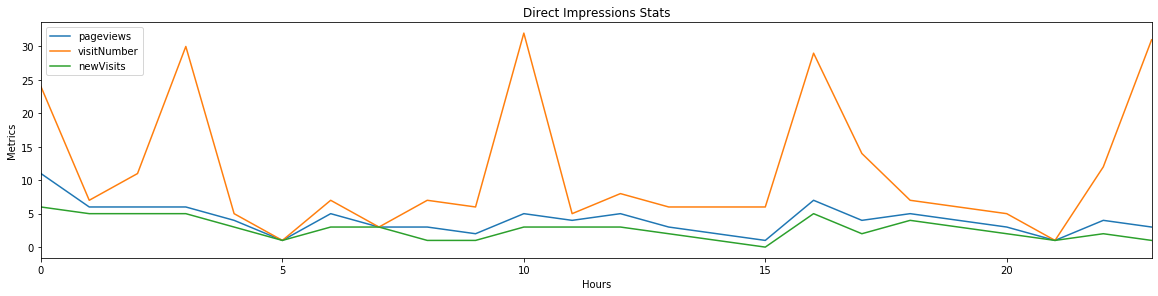

In [43]:
# Now lets plot it.
raw[raw['source'] == '(direct)'].groupby('hours').agg({'pageviews':'count','visitNumber':'sum','newVisits':'count'})\
.plot(figsize=(16,4))

plt.tight_layout()
plt.xlabel('Hours')
plt.ylabel('Metrics')
plt.title('Direct Impressions Stats')

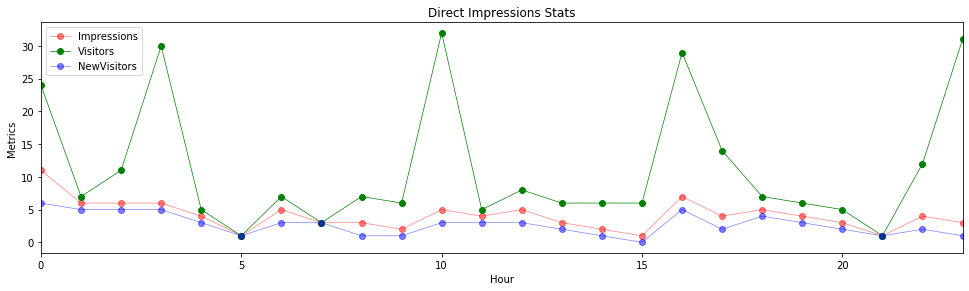

In [44]:
#matplotlib OO method
fig = plt.figure(figsize=(16,4))

axes = fig.add_axes([0.1,0.1,0.8,0.8])
axes.plot(raw[raw['source'] == '(direct)'].groupby('hours').agg({'pageviews':'count'}),color='red',marker='o',label='Impressions',lw=0.7,alpha=0.5)
axes.plot(raw[raw['source'] == '(direct)'].groupby('hours').agg({'visitNumber':'sum'}),color='green',marker='o',label='Visitors',linewidth=0.7)
axes.plot(raw[raw['source'] == '(direct)'].groupby('hours').agg({'newVisits':'count'}),color='blue',marker = 'o',label='NewVisitors',linewidth=0.7,alpha=0.5)
axes.set_xlim([0,23])
axes.set_ylabel('Metrics')
axes.set_xlabel('Hour')
axes.set_title('Direct Impressions Stats')
axes.legend(loc=0)

In [45]:
#seaborn method
df = raw[raw['source'] == '(direct)'].groupby('hours').agg({'pageviews':'count','visitNumber':'sum','newVisits':'count'})

In [46]:
df = df.reset_index()

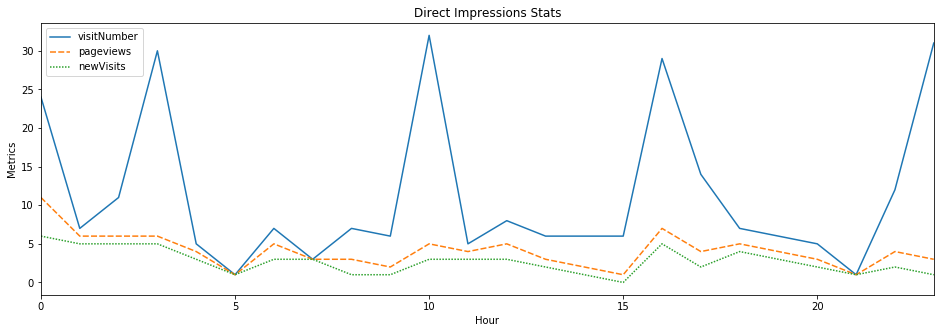

In [47]:
plt.figure(figsize=(16,5))
sns.lineplot(data=df[['visitNumber','pageviews','newVisits']],hue='hours',style="hours")
plt.xlim([0,23])
plt.ylabel('Metrics')
plt.xlabel('Hour')
plt.title('Direct Impressions Stats')
plt.legend(loc=0)

##### Query Number 2:

#### Plot the average number of Visitors throughout the top 5 countries!

In [48]:
# Lets create a query first
raw.groupby(['country']).agg({'visitNumber':'mean'}).sort_values(by='visitNumber',ascending = False).head(5)

,visitNumber
country,
Italy,26.000000
China,6.000000
Russia,3.000000
Spain,3.000000
Poland,2.666667


Text(0, 0.5, 'Average Visitors')

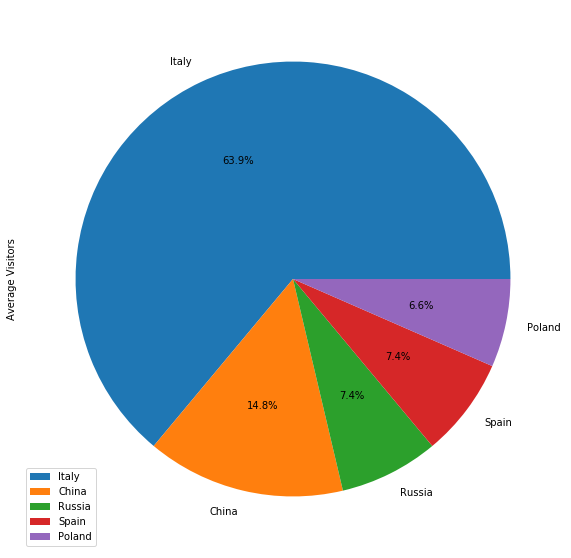

In [49]:
raw.groupby(['country']).agg({'visitNumber':'mean'}).sort_values(by='visitNumber',ascending = False).head(5).plot(y='visitNumber',kind='pie',figsize=(10, 10),autopct='%1.1f%%')
plt.ylabel('Average Visitors')

In [50]:
#matplotlib OO method
x = raw.groupby(['country']).agg({'visitNumber':'mean'}).sort_values(by='visitNumber',ascending = False).head(5).reset_index()

In [51]:
x

,country,visitNumber
0,Italy,26.000000
1,China,6.000000
2,Russia,3.000000
3,Spain,3.000000
4,Poland,2.666667


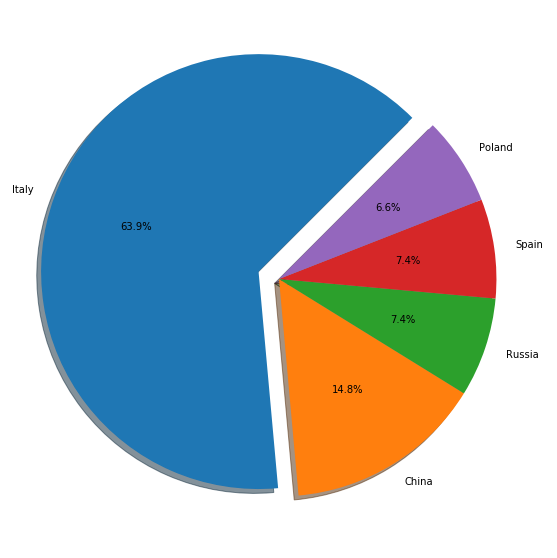

In [52]:
fig = plt.figure(figsize=(10,10))
explode = (0.1,0,0,0,0)
labels = x['country']
sizes = x['visitNumber']
plt.pie(sizes,labels=labels,shadow=True,explode=explode,autopct='%1.1f%%',startangle=45)
plt.show()

##### Query Number 3:

#### Plot a bar graph showing Number Of Vistiors through-out Devices!

In [53]:
#Lets Code
raw.groupby('operatingSystem').agg({'visitNumber':'sum'}).head(10)

,visitNumber
operatingSystem,
Android,58
Chrome OS,11
Linux,2
Macintosh,111
Windows,37
Windows Phone,1
iOS,51


Text(0, 0.5, 'Visitors')

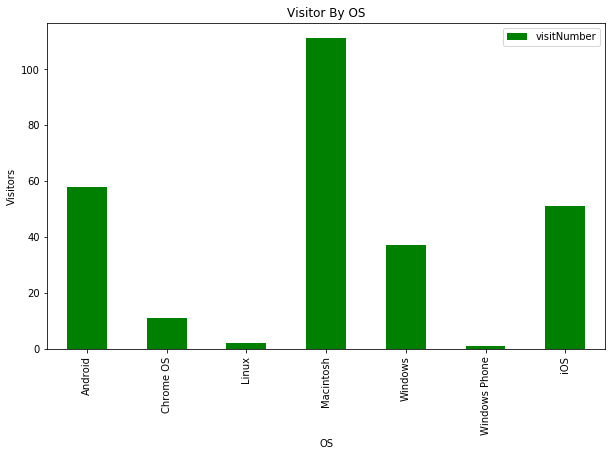

In [54]:
#Lets Plot
raw.groupby('operatingSystem').agg({'visitNumber':'sum'}).plot(kind='bar',color='green',figsize=(10,6))
plt.title('Visitor By OS')
plt.xlabel('OS')
plt.ylabel('Visitors')

In [55]:
#matplotlib OO method

y = raw.groupby('operatingSystem').agg({'visitNumber':'sum'}).reset_index()

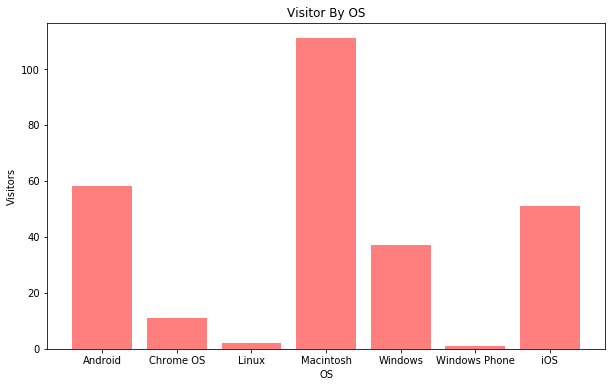

In [56]:
fig = plt.figure(figsize=(10,6))

objects = y['operatingSystem']
y_pos = np.arange(len(objects))
performance = y['visitNumber']

plt.bar(y_pos,performance,data=y, align='center',color='red',alpha=0.5)
plt.xticks(y_pos, objects)
plt.title('Visitor By OS')
plt.xlabel('OS')
plt.ylabel('Visitors')
plt.show()

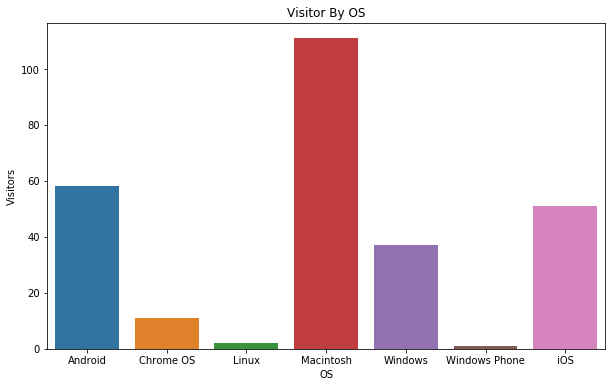

In [59]:
## seaborn method
fig = plt.figure(figsize=(10,6))

sns.barplot(x='operatingSystem',y='visitNumber',data=y)

plt.title('Visitor By OS')
plt.xlabel('OS')
plt.ylabel('Visitors')
plt.show()

##### Query Number 4:

#### Plot the disturbution of % Visitor through-out the countries around the dateset. 

In [60]:
# lets code this first
raw.groupby('country').agg({'visitNumber':'sum'}).head(3)

,visitNumber
country,
Australia,4
Austria,1
Brazil,2


In [62]:
x = raw.groupby('country').agg({'visitNumber':'sum'}).reset_index()

In [69]:
x['%Visit'] = (x['visitNumber']/x['visitNumber'].sum())*100

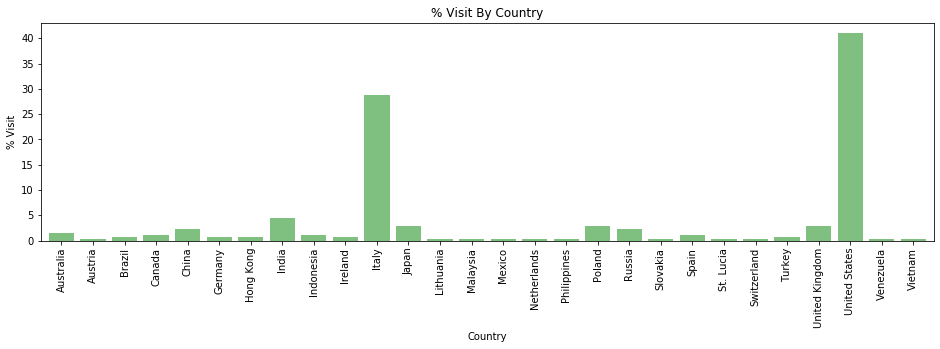

In [76]:
fig = plt.figure(figsize=(16,4))
x.groupby('country').sum()['%Visit'].plot(kind='bar',color='green',alpha=0.5,width=0.8)
plt.title('% Visit By Country')
plt.xlabel('Country')
plt.ylabel('% Visit')
plt.show()

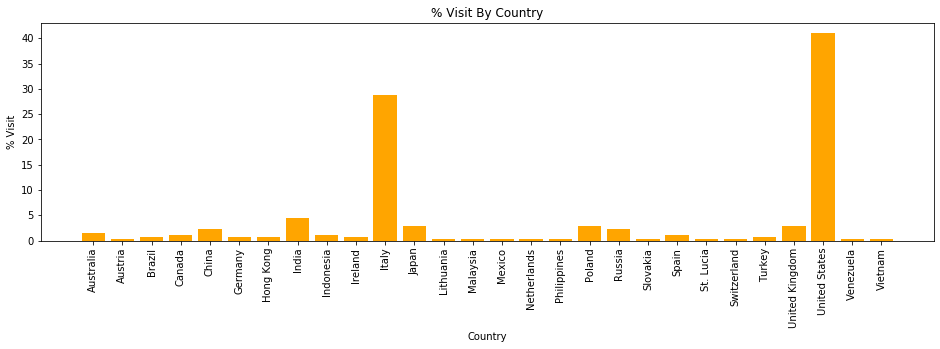

In [85]:
## matplotlib OO method

fig = plt.figure(figsize=(16,4))

objects = x['country']
y_pos = np.arange(len(objects))
performance = x['%Visit']
plt.bar(y_pos,performance,data=x,color='orange')
plt.xticks(y_pos, objects,rotation='vertical')
plt.title('% Visit By Country')
plt.xlabel('Country')
plt.ylabel('% Visit')
plt.show()

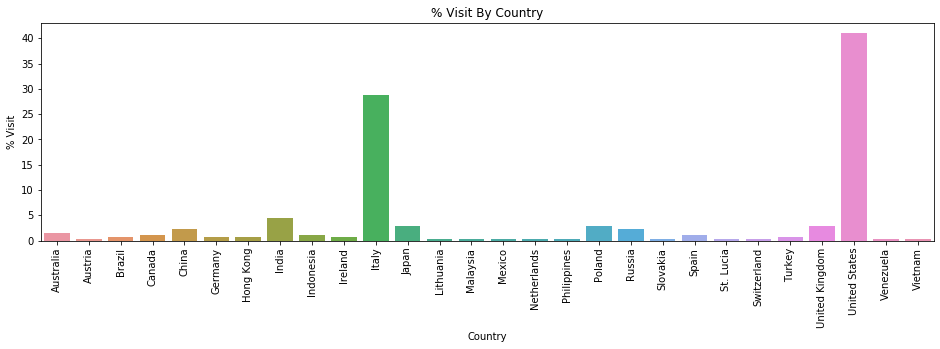

In [89]:
# seaborn method
fig = plt.figure(figsize=(16,4))

sns.barplot(x='country',y='%Visit',data=x)

plt.xticks(rotation='vertical')
plt.title('% Visit By Country')
plt.xlabel('Country')
plt.ylabel('% Visit')
plt.show()

#### I hope, I had done fair enough job with this dataset, if you want to suggest any changes please do comment OR mail me the suggestion at vidharth.kate@gmail.com